## FNN Metadata Model <a class="anchor"  id="chapter9"></a> 

### Building FNN Model Architecture  <a class="anchor"  id="section_9_1"></a>

In [25]:
# Define the neural network model
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Add an additional linear layer
        self.relu2 = nn.ReLU()  # Add an additional ReLU activation
        self.fc3 = nn.Linear(hidden_size, output_size)  # Adjust the input size of the last linear layer
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)  # Pass through the additional linear layer
        x = self.relu2(x)  # Pass through the additional ReLU activation
        x = self.fc3(x)  # Pass through the adjusted last linear layer
        return x


# Define the custom dataset for text classification
class TextDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Split the data into train and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(train_cleaned[['word_count', 'unique_word_count', 'character_count', 'hashtag_count', 'mention_count', 'url_count', 'capitalized_word_count', 'capitalized_word_proportion', 'spelling_error_count', 'has_spelling_errors']].values,
                                                                            train_cleaned['target'].values, test_size=0.2, random_state=42)
# Scale the features using StandardScaler
scaler = StandardScaler()
scaler.fit(train_features)
train_features_scaled = scaler.transform(train_features)
val_features_scaled = scaler.transform(val_features)

# Create custom datasets for train and validation sets with scaled features
train_dataset = TextDataset(train_features_scaled, train_labels)
val_dataset = TextDataset(val_features_scaled, val_labels)

batch_size = 16

# Define hyperparameters
input_size = train_features.shape[1]  # Update input_size to match number of features after scaling
hidden_size = 256
output_size = 2  # Set output_size to 2 for binary classification with 2 classes

# Create an instance of the text classifier model
model = TextClassifier(input_size, hidden_size, output_size)

# Move the model to the desired device (e.g. GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Use torchinfo to visualize model architecture and output shapes
from torchinfo import summary
summary(model, input_size=(batch_size, input_size), device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [16, 2]                   --
├─Linear: 1-1                            [16, 256]                 2,816
├─ReLU: 1-2                              [16, 256]                 --
├─Linear: 1-3                            [16, 256]                 65,792
├─ReLU: 1-4                              [16, 256]                 --
├─Linear: 1-5                            [16, 2]                   514
Total params: 69,122
Trainable params: 69,122
Non-trainable params: 0
Total mult-adds (M): 1.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.28
Estimated Total Size (MB): 0.34

### Training and Validation  <a class="anchor"  id="section_9_2"></a>

Epoch 1 - Avg Train Loss: 0.6393 | Avg Val Loss: 0.6166
  Accuracy: 0.66
  F1 Score: 0.59
  Precision: 0.60
  Recall: 0.62
Epoch 2 - Avg Train Loss: 0.6234 | Avg Val Loss: 0.6097
  Accuracy: 0.68
  F1 Score: 0.60
  Precision: 0.64
  Recall: 0.61
Epoch 3 - Avg Train Loss: 0.6155 | Avg Val Loss: 0.6093
  Accuracy: 0.69
  F1 Score: 0.61
  Precision: 0.64
  Recall: 0.62
Epoch 4 - Avg Train Loss: 0.6120 | Avg Val Loss: 0.6108
  Accuracy: 0.68
  F1 Score: 0.58
  Precision: 0.66
  Recall: 0.56
Epoch 5 - Avg Train Loss: 0.6089 | Avg Val Loss: 0.6034
  Accuracy: 0.69
  F1 Score: 0.56
  Precision: 0.68
  Recall: 0.52
Epoch 6 - Avg Train Loss: 0.6079 | Avg Val Loss: 0.6024
  Accuracy: 0.69
  F1 Score: 0.60
  Precision: 0.65
  Recall: 0.59
Epoch 7 - Avg Train Loss: 0.6036 | Avg Val Loss: 0.5998
  Accuracy: 0.69
  F1 Score: 0.57
  Precision: 0.69
  Recall: 0.53
Epoch 8 - Avg Train Loss: 0.6018 | Avg Val Loss: 0.6076
  Accuracy: 0.68
  F1 Score: 0.54
  Precision: 0.67
  Recall: 0.49
Epoch 9 - Avg Tr

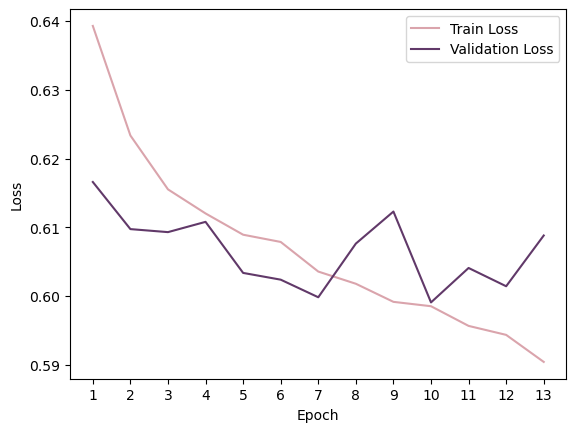

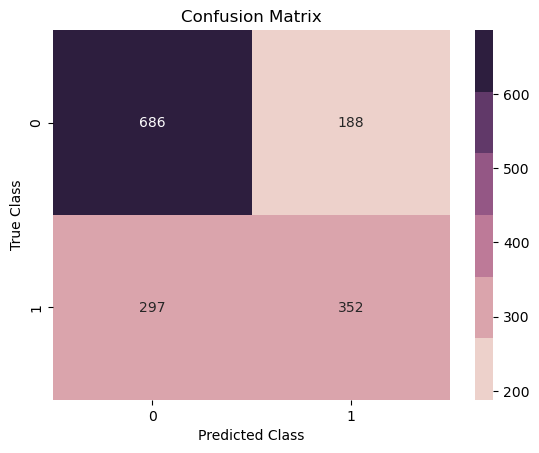

In [26]:
# Define loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store training and validation loss
train_losses = []
val_losses = []

epochs = 20
best_val_loss = float('inf') # Store the best validation loss
early_stop_count = 0 # Counter for early stopping
patience = 3 # Number of epochs with no improvement in validation loss to trigger early stopping

for epoch in range(epochs):
    # Training
    train_loss = 0
    train_steps = 0
    model.train() # Set to training mode
    for i, (inputs, labels) in enumerate(train_dataloader):
        # Load the batch onto the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients from previous batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        batch_loss = loss(outputs, labels)
        train_loss += batch_loss.item()

        # Backward pass
        batch_loss.backward()

        # Update the parameters
        optimizer.step()

        # Increment the training steps
        train_steps += 1

    # Compute the average training loss for the epoch
    avg_train_loss = train_loss / train_steps
    train_losses.append(avg_train_loss)

    # Validation
    val_true_labels = []
    val_pred_labels = []
    total_f1 = 0
    total_precision = 0
    total_recall = 0
    val_loss = 0
    val_steps = 0
    model.eval() # Set to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        for i, (inputs, labels) in enumerate(val_dataloader):
            # Load the batch onto the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            batch_loss = loss(outputs, labels)
            val_loss += batch_loss.item()

            # Move logits and labels to CPU
            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Calculate F1 score, precision, and recall
            f1 = f1_score(label_ids, np.argmax(logits, axis=1), zero_division=1)
            precision = precision_score(label_ids, np.argmax(logits, axis=1), zero_division=1)
            recall = recall_score(label_ids, np.argmax(logits, axis=1), zero_division=1)
            total_f1 += f1
            total_precision += precision
            total_recall += recall

            # Compute the predictions and append to lists
            pred_labels = np.argmax(logits, axis=1)
            val_pred_labels.extend(pred_labels)
            val_true_labels.extend(label_ids)

            # Increment the validation steps
            val_steps += 1

    # Compute the average validation loss and metrics for the epoch
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    avg_val_loss = val_loss / val_steps
    val_losses.append(avg_val_loss)

    avg_val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    avg_f1 = total_f1 / val_steps
    avg_precision = total_precision / val_steps
    avg_recall = total_recall / val_steps

    print(f"Epoch {epoch+1} - Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f}")
    print("  Accuracy: {0:.2f}".format(val_accuracy))
    print("  F1 Score: {0:.2f}".format(avg_f1))
    print("  Precision: {0:.2f}".format(avg_precision))
    print("  Recall: {0:.2f}".format(avg_recall))
    
    # Check if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    # Check if we should early stop
        if early_stop_count >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
            break

# Plot the training and validation losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color=colors[1])
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color=colors[4])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses) + 1), range(1, len(train_losses) + 1)) 
plt.legend()
plt.show()
        
cm = confusion_matrix(val_true_labels, val_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap=colors)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()